In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy
import sklearn
from scipy import stats
import tensorflow as tf

2023-08-18 15:33:43.185066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 1100)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [4]:
def autocorrelation_fft(data):
    data = data - np.mean(data)  # Remove the mean
    n = len(data)
    
    # Compute the power spectral density (PSD)
    data_fft = np.fft.fft(data, n=2*n)  # Zero-padding for avoiding circular convolution
    psd = np.abs(data_fft)**2
    
    # Compute the inverse Fourier transform of the PSD
    autocorr = np.fft.ifft(psd)
    
    # Keep only the positive lags and normalize the result
    autocorr = autocorr[:n].real
    autocorr /= autocorr[0]

    return autocorr

In [1]:
## The code below is used to generate the training data for the neural network

t_span = (0, 1100) # Time span
dt = 0.001  # Time step

t, y = euler_maruyama(initial_state, t_span, dt, epsilon)   # Solve the SDE
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Extract the desired values
U = y[4]  # Extract U values
psi_e = y[0]  # Extract psi_e values
psi_p = y[2]  # Extract psi_p values

# Find the index corresponding to time t=100
start_index = int(100 / dt) 

# Slice arrays starting from the index of t=100
t = t[start_index:]
t = t - t[0]
y = y[:, start_index:]
U = U[start_index:]
R = R[start_index:]
psi_e = psi_e[start_index:]
psi_p = psi_p[start_index:]

NameError: name 'euler_maruyama' is not defined

In [6]:
# Create a DataFrame with U and R
df = pd.DataFrame({'U': U, 'R': R})
df.to_csv('./data/train_data_longtime_210000.csv', index=False) #save the dataframe as a csv file

# save the variables t and y as a numpy array
np.savez('./data/train_data_numpy_longtime_210000.npz', t=t, y=y)

In [4]:
# load the variables t and y from the numpy file
data = np.load('./data/train_data_numpy_longtime_210000.npz')
t = data['t']
y = data['y']
U = y[4]  # Extract U values
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2]

# From the data created by the simulation, we calculate the conditional probability P(R|U) using a 2D histogram

In [6]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

r_bins = np.linspace(R.min(), -R.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)


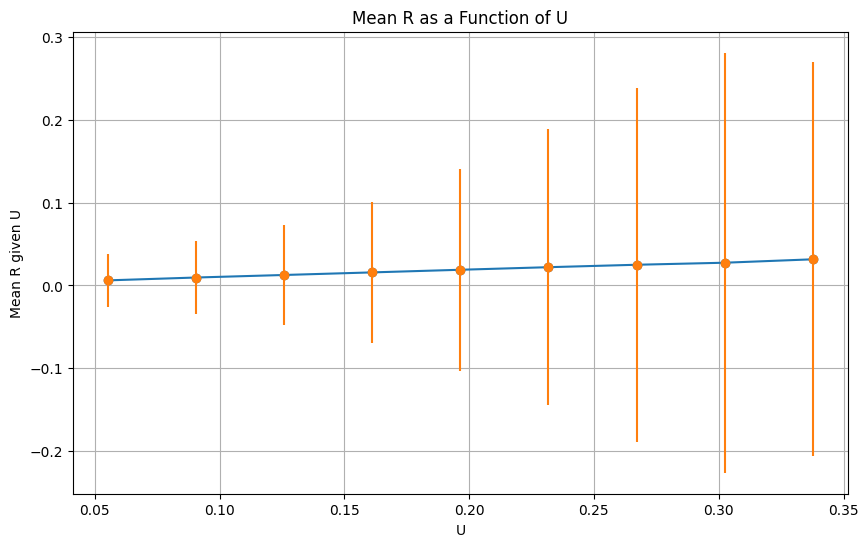

In [20]:
# First, compute the center of each R bin
r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

# Initialize an array to store the mean R for each U bin
mean_R_given_U = np.zeros(p_r_given_u.shape[0])
std_R_given_U = np.zeros(p_r_given_u.shape[0])

# Loop over each U bin
for i in range(p_r_given_u.shape[0]):
    
    # Compute the weighted average of R for this U bin
    mean_R_given_U[i] = np.sum(r_centers * p_r_given_u[i,:])
    std_R_given_U[i] = np.sqrt(np.sum((r_centers - mean_R_given_U[i])**2 * p_r_given_u[i,:]))

# Now, compute the center of each U bin
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])

# Plot mean R as a function of U
plt.figure(figsize=(10,6))
plt.plot(u_centers, mean_R_given_U ,'-', marker='o')
# plot the error bars (1 standard deviation)
plt.errorbar(u_centers, mean_R_given_U, yerr=std_R_given_U, fmt='o')
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U')
plt.grid(True)
plt.show()

In [25]:
# Binning the U values
U_bin_number = np.digitize(U, u_bins)

# Initialize empty arrays to store the R values for each U bin
R_values_in_bins = [[] for _ in range(num_bins)]

# Loop over the U and R data
for i in range(len(U)):
    
    # Get the bin number for this U value
    bin_number = U_bin_number[i] - 1  # subtract 1 because np.digitize bins are 1-indexed
    if bin_number==9:
        bin_number=8
    
    # Append the corresponding R value to the appropriate bin
    if bin_number < num_bins:  # ignore U values that fall in the overflow bin
        R_values_in_bins[bin_number].append(R[i])

# Now you have lists of R values for each U bin
# You could convert these lists to numpy arrays if you want to perform numpy operations on them
R_values_in_bins = [np.array(bin_values) for bin_values in R_values_in_bins]

In [45]:
R_values_in_bins = R_values_in_bins[0:9]

In [49]:
R_mean_in_bins = np.zeros(len(R_values_in_bins))
R_std_in_bins = np.zeros(len(R_values_in_bins))
R_sem_in_bins = np.zeros(len(R_values_in_bins))
R_var_in_bins = np.zeros(len(R_values_in_bins))

In [50]:
for i in range(len(R_mean_in_bins)):

    R_mean_in_bins[i] = np.mean(R_values_in_bins[i])
    R_std_in_bins[i] = np.std(R_values_in_bins[i])
    R_sem_in_bins[i] = R_std_in_bins[i]/np.sqrt(len(R_values_in_bins[i]))
    R_var_in_bins[i] = R_std_in_bins[i]**2

print(R_mean_in_bins)
print(R_std_in_bins)
print(R_sem_in_bins)
print(R_var_in_bins)

[0.00682464 0.00984147 0.01274918 0.01576596 0.01890739 0.0219809
 0.02490021 0.02748948 0.03094517]
[0.03008579 0.04214507 0.05913452 0.08345081 0.12042098 0.16559261
 0.21301105 0.25257924 0.23727843]
[3.78212982e-05 8.08192531e-06 5.94471957e-06 1.02762886e-05
 3.12204096e-05 1.15555081e-04 4.50081056e-04 1.76784519e-03
 5.88977907e-03]
[0.00090515 0.00177621 0.00349689 0.00696404 0.01450121 0.02742091
 0.04537371 0.06379627 0.05630105]


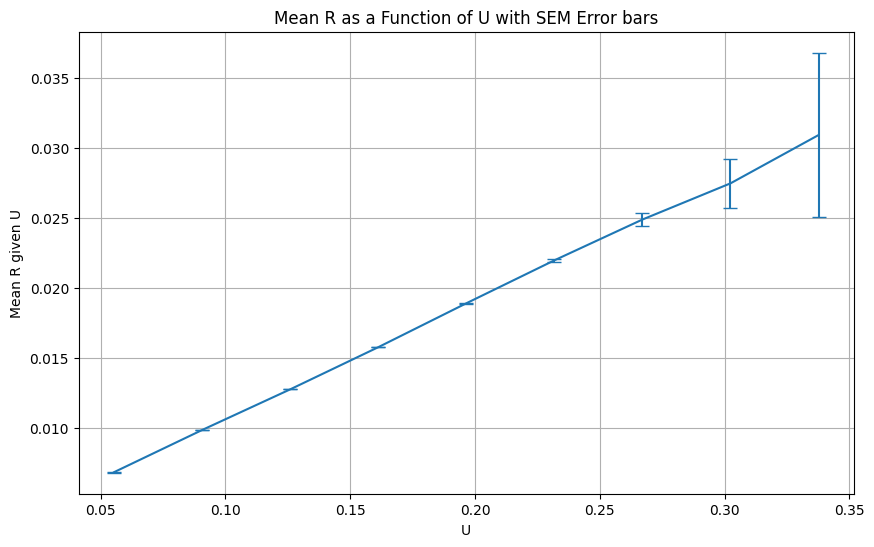

In [52]:
plt.figure(figsize=(10,6))
plt.errorbar(u_centers, R_mean_in_bins, yerr=R_sem_in_bins, fmt='-', capsize=5)
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U with SEM Error bars')
plt.grid(True)
plt.show()

In [53]:
with open("variables_2D_hist.pickle", "wb") as f:
    pickle.dump((u_centers, R_mean_in_bins, std_R_given_U, R_sem_in_bins), f)

In [8]:
output_val = np.zeros(len(U))

del_R = r_bins[1] - r_bins[0]

# loop over the length of U:
for i in range(len(U)):
    # Find the index of the U bin that U[i] belongs to
    u_index = np.digitize(U[i], u_bins) - 1
    
    # Find the index of the R bin that R[i] belongs to
    r_index = np.digitize(R[i], r_bins) - 1

    if u_index == 9:
        u_index = 8
    if r_index == 49:
        r_index = 48
    # display a visible bar with the progress percentage
    if i % 100000 == 0:
        print(f'{i/len(U)*100:.2f}%')

    output_val[i] = p_r_given_u[u_index, r_index] / del_R


0.00%
0.05%
0.10%
0.14%
0.19%
0.24%
0.29%
0.33%
0.38%
0.43%
0.48%
0.52%
0.57%
0.62%
0.67%
0.71%
0.76%
0.81%
0.86%
0.91%
0.95%
1.00%
1.05%
1.10%
1.14%
1.19%
1.24%
1.29%
1.33%
1.38%
1.43%
1.48%
1.52%
1.57%
1.62%
1.67%
1.72%
1.76%
1.81%
1.86%
1.91%
1.95%
2.00%
2.05%
2.10%
2.14%
2.19%
2.24%
2.29%
2.33%
2.38%
2.43%
2.48%
2.53%
2.57%
2.62%
2.67%
2.72%
2.76%
2.81%
2.86%
2.91%
2.95%
3.00%
3.05%
3.10%
3.14%
3.19%
3.24%
3.29%
3.33%
3.38%
3.43%
3.48%
3.53%
3.57%
3.62%
3.67%
3.72%
3.76%
3.81%
3.86%
3.91%
3.95%
4.00%
4.05%
4.10%
4.14%
4.19%
4.24%
4.29%
4.34%
4.38%
4.43%
4.48%
4.53%
4.57%
4.62%
4.67%
4.72%
4.76%
4.81%
4.86%
4.91%
4.95%
5.00%
5.05%
5.10%
5.15%
5.19%
5.24%
5.29%
5.34%
5.38%
5.43%
5.48%
5.53%
5.57%
5.62%
5.67%
5.72%
5.76%
5.81%
5.86%
5.91%
5.96%
6.00%
6.05%
6.10%
6.15%
6.19%
6.24%
6.29%
6.34%
6.38%
6.43%
6.48%
6.53%
6.57%
6.62%
6.67%
6.72%
6.77%
6.81%
6.86%
6.91%
6.96%
7.00%
7.05%
7.10%
7.15%
7.19%
7.24%
7.29%
7.34%
7.38%
7.43%
7.48%
7.53%
7.58%
7.62%
7.67%
7.72%
7.77%
7.81%
7.86%
7.91

In [7]:
# output_val = np.zeros(len(U))

# del_R = r_bins[1] - r_bins[0]

# # loop over the length of U:
# for i in range(len(U)):
#     # Find the index of the U bin that U[i] belongs to
#     u_index = np.digitize(U[i], u_bins) - 1
    
#     # Find the index of the R bin that R[i] belongs to
#     r_index = np.digitize(R[i], r_bins) - 1

#     if u_index == 9:
#         u_index = 8
#     if r_index == 49:
#         r_index = 48
#     # print out a percentage of the progress
#     if i % 100000 == 0:
#         print(f'{i/len(U)*100:.2f}%')

#     # Compute the 2D histogram of R and U
#     hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

#     # Compute the conditional probability P(R|U) by normalizing each U bin by its total count
#     p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)

#     output_val[i] = p_r_given_u[u_index, r_index] / del_R

In [8]:
# df2 = pd.DataFrame({'U': U, 'R': R, 'output': output_val})
# df2.to_csv('./data/train_data_histogram_longtime_2100000.csv', index=False) #save the dataframe as a csv file


In [9]:
df['output_val'] = output_val
# df.to_csv('./data/train_data_histogram_longtime_2100000.csv', index=False) #save the dataframe as a csv file

In [10]:
df.to_csv('./data/train_data_histogram_longtime_2100000.csv', index=False)

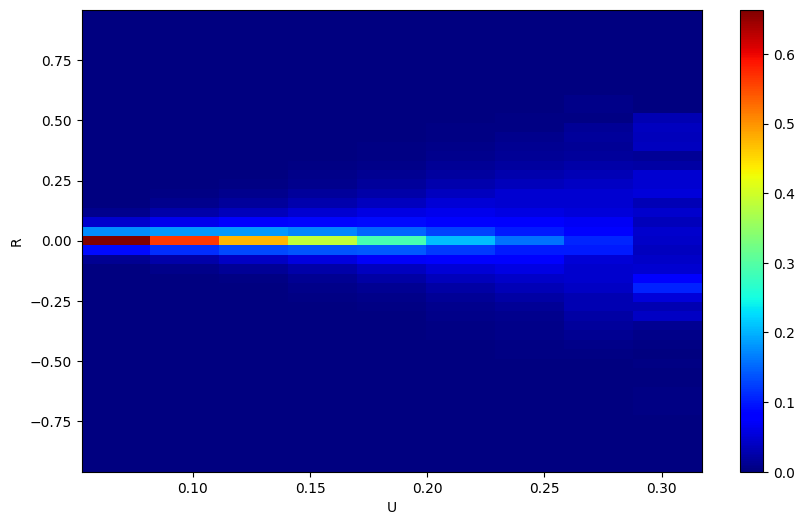

In [21]:
# plot the histogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(u_bins, r_bins, p_r_given_u.T, cmap='jet')
plt.xlabel('U')
plt.ylabel('R')
plt.colorbar()
plt.show()


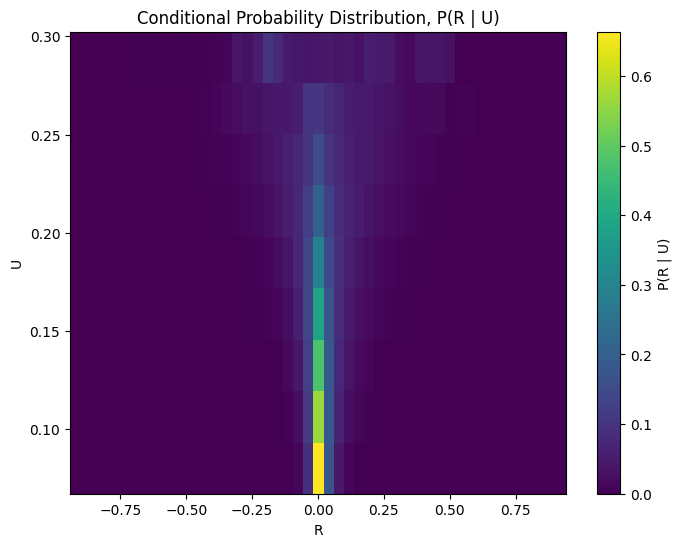

In [61]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
r_bin_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_r_given_u, extent=[r_bin_centers.min(), r_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(R | U)')

# Set the labels
plt.xlabel('R')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(R | U)')

# Show the plot
plt.show()

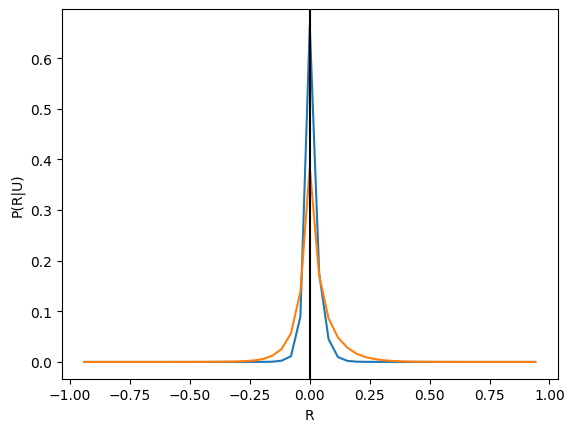

In [66]:
plt.plot(r_bin_centers, p_r_given_u[0,:])
plt.plot(r_bin_centers, p_r_given_u[3,:])
plt.axvline(x=0, color='k')
plt.xlabel('R')
plt.ylabel('P(R|U)')
# plt.legend(['U = 0.0', 'U = 0.3'])
plt.show()

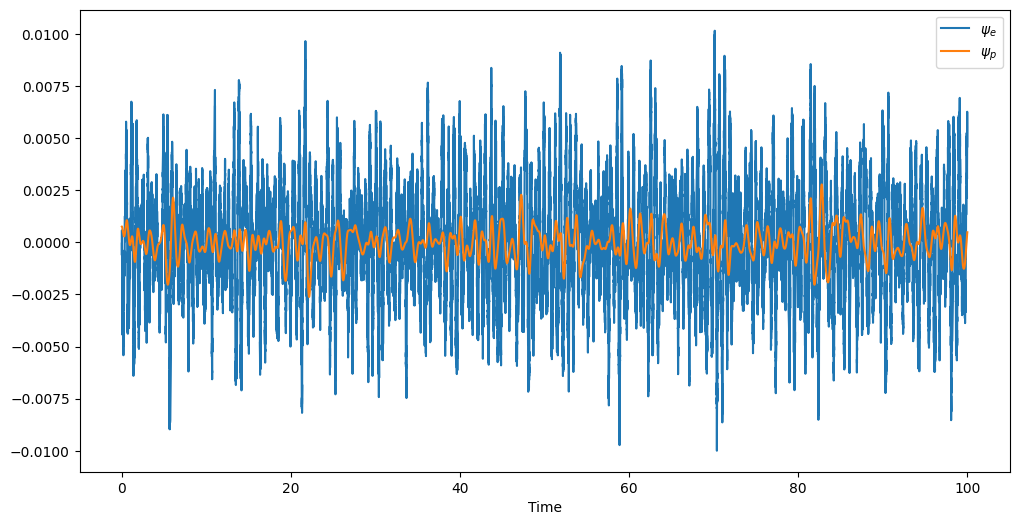

In [72]:
# Plot psie_e and psie_p against time
plt.figure(figsize=(12, 6))
plt.plot(t[0:int(100/0.001)], psi_e[0:int(100/0.001)], label='$\psi_e$')
plt.plot(t[0:int(100/0.001)], psi_p[0:int(100/0.001)], label='$\psi_p$')

plt.xlabel('Time')

plt.legend()
plt.show()


In [78]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

psi_e_bins = np.linspace(psi_e.min(), -psi_e.min(), 50)
psi_p_bins = np.linspace(psi_p.min(), -psi_p.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, psi_e_edges = np.histogram2d(U, psi_e, bins=[u_bins, psi_e_bins], density=True)
hist_p, u_edges, psi_p_edges = np.histogram2d(U, psi_p, bins=[u_bins, psi_p_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_psi_e_given_u = hist / np.sum(hist, axis=1, keepdims=True)
p_psi_p_given_u = hist_p / np.sum(hist_p, axis=1, keepdims=True)


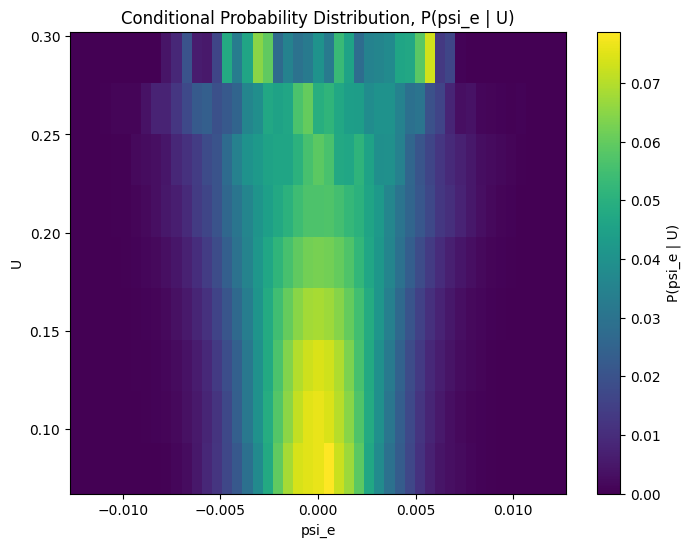

In [79]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
psi_e_bin_centers = 0.5 * (psi_e_edges[1:] + psi_e_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_psi_e_given_u, extent=[psi_e_bin_centers.min(), psi_e_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(psi_e | U)')

# Set the labels
plt.xlabel('psi_e')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(psi_e | U)')

# Show the plot
plt.show()

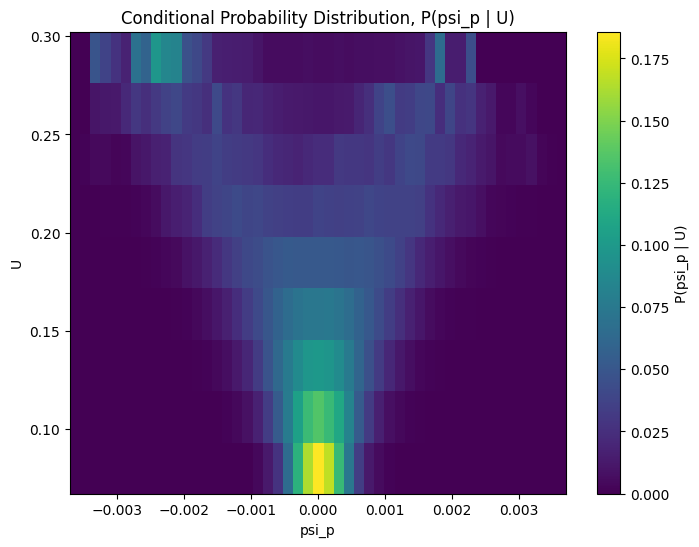

In [81]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
psi_p_bin_centers = 0.5 * (psi_p_edges[1:] + psi_p_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_psi_p_given_u, extent=[psi_p_bin_centers.min(), psi_p_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(psi_p | U)')

# Set the labels
plt.xlabel('psi_p')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(psi_p | U)')

# Show the plot
plt.show()

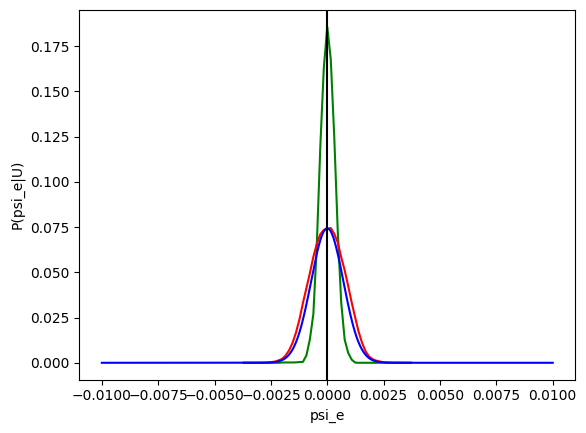

In [115]:
plt.plot(psi_p_bin_centers, p_psi_p_given_u[0,:],'g')
plt.plot(psi_p_bin_centers, p_psi_p_given_u[3,:],'r' )
plt.plot(x, y/7500, 'b')
plt.axvline(x=0, color='k')
plt.xlabel('psi_e')
plt.ylabel('P(psi_e|U)')
# plt.legend(['U = 0.0', 'U = 0.3'])
plt.show()

In [86]:
mean_psi_e = np.mean(psi_e)
mean_psi_p = np.mean(psi_p)
print(mean_psi_e)
print(mean_psi_p)

var_psi_e = np.var(psi_e)
var_psi_p = np.var(psi_p)
print(var_psi_e)
print(var_psi_p)

4.1714860188498506e-07
-1.0296962535920914e-06
8.697347204370003e-06
5.117092662040795e-07


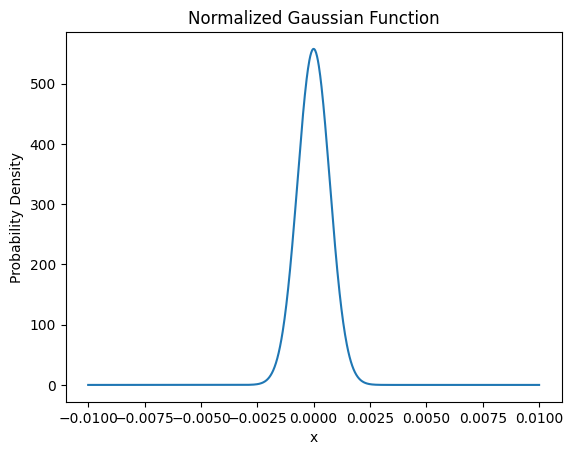

In [126]:
def gaussian(x, mean, variance):
    return (1. / np.sqrt(2*np.pi*variance)) * np.exp(-((x - mean)**2 / (2*variance)))

# Define parameters
mean = mean_psi_p
variance = var_psi_p
x = np.linspace(-0.01, 0.01, 1000)

# Generate Gaussian function
y = gaussian(x, mean, variance)

# Plot
plt.plot(x, y)
plt.title('Normalized Gaussian Function')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

Text(0.5, 1.0, 'Distribution of Y')

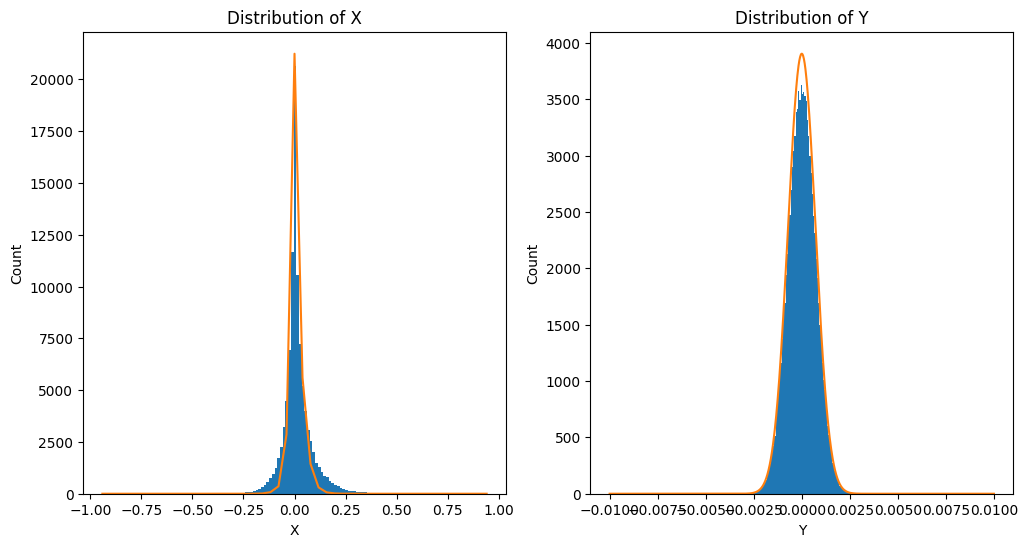

In [144]:
# Define means, variances, and covariance
mean_X = 0
mean_Y = 0
variance_X = var_psi_e
variance_Y = var_psi_p
covariance_XY = 4.07821003e-07  # Covariance between X and Y

# Define mean vector and covariance matrix
mean = [mean_X, mean_Y]
cov = [[variance_X, covariance_XY], [covariance_XY, variance_Y]]

# Generate random data
num_samples = 100000
X, Y = np.random.multivariate_normal(mean, cov, num_samples).T

# plot the distributions of X and Y
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X*Y*0.25 * k * (k_plus**2 - k_e**2), bins=100)
plt.plot(r_bin_centers, p_r_given_u[0,:]*32000)
plt.xlabel('X')
plt.ylabel('Count')
plt.title('Distribution of X')

plt.subplot(1, 2, 2)
plt.hist(Y, bins=100)
plt.plot(x, y*7)
plt.xlabel('Y')
plt.ylabel('Count')
plt.title('Distribution of Y')


In [ ]:
# Calculate autocorrelation functions for U and R
U_autocorr = autocorrelation_fft(U)

In [ ]:
#Replace df['R'] with Rolling mean of R with window size 1000
# df['R'] = df['R'].rolling(1000).mean()

# Add autocorrelation of U to the DataFrame
df['U_autocorr'] = U_autocorr

# moving average of U (window size 100)
df['mov_avg'] = df['U'].rolling(100).mean()

# moving average of U (window size 1000)
df['mov_avg2'] = df['U'].rolling(1000).mean()

# moving average of U (window size 10000)
df['mov_avg3'] = df['U'].rolling(10000).mean()

df = df.dropna() #drop the rows with NaN values

df.to_csv('./data/train_data_Uautocorr_longtime.csv', index=False) #save the dataframe as a csv file


In [12]:
U_ss = U[::8500]
R_ss = R[::8500]

# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U_ss.min(), U_ss.max(), num_bins)

r_bins = np.linspace(R_ss.min(), -R_ss.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, r_edges = np.histogram2d(U_ss, R_ss, bins=[u_bins, r_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)

output_val_ss = np.zeros(len(U_ss))

del_R = r_bins[1] - r_bins[0]

# loop over the length of U:
for i in range(len(U_ss)):
    # Find the index of the U bin that U[i] belongs to
    u_index = np.digitize(U_ss[i], u_bins) - 1
    
    # Find the index of the R bin that R[i] belongs to
    r_index = np.digitize(R_ss[i], r_bins) - 1

    if u_index == 9:
        u_index = 8
    if r_index == 49:
        r_index = 48
    # display a visible bar with the progress percentage
    if i % 100000 == 0:
        print(f'{i/len(U_ss)*100:.2f}%')

    output_val_ss[i] = p_r_given_u[u_index, r_index] / del_R

df3 = pd.DataFrame({'U': U_ss, 'R': R_ss, 'output': output_val_ss})
df3.to_csv('./data/train_data_histogram_longtime_subsampled_210000.csv', index=False) #save the dataframe as a csv file


0.00%


In [34]:
#From the df dataframe, subsample the rows with a step size of 8500 and save it as a new dataframe and then save it as a csv file
df2 = df.iloc[::8500, :]
df2.to_csv('./data/train_data_subsampled_Uautocorr_longtime.csv', index=False)

In [2]:
# import a df from a csv file and course grain it with a new time step of 0.1 instead of the premade 0.001
df4 = pd.read_csv('./data/train_data_histogram_longtime_210000.csv')
df4 = df4.iloc[::10, :]

In [3]:
df4.to_csv('./data/train_data_histogram_longtime_210000_coursegrained10.csv', index=False)

In [25]:
#display nan values
print(df.isnull().sum())

U                  0
R                  0
std               99
std2             999
var               99
var2             999
mov_avg           99
mov_avg2         999
mov_avg3        9999
exp_mov_avg        0
exp_mov_avg2       0
detrend1          99
detrend2         999
detrend3        9999
dtype: int64


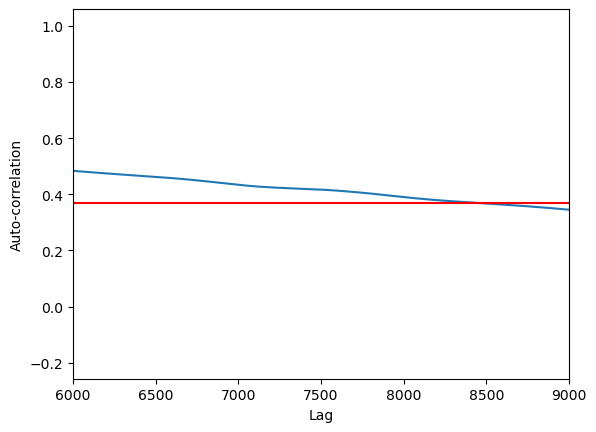

In [8]:
# Calculate U'
U_prime = U - np.mean(U)

# Compute the correlation with FFT
U_prime_fft = np.fft.fft(U_prime)
U_prime_fft = np.abs(U_prime_fft) ** 2
U_prime_fft = np.fft.ifft(U_prime_fft)
U_prime_fft = np.real(U_prime_fft)

# Extract the positive lags
U_prime_fft = U_prime_fft[:len(U_prime_fft) // 2]

# Normalize the auto-correlation function
U_prime_fft = U_prime_fft / U_prime_fft[0]

# Plot the auto-correlation function
plt.plot(U_prime_fft)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
#plt.xlim(6000,9000)
plt.axhline(y=1/np.e, color='r', linestyle='-')
plt.show()